In [26]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [27]:
df = pd.read_csv("./Violations-2012.csv")
print df.info()
df.head()
# violation_date_closed data needs to be imputated for NaN/NaT values if we perform a model evaluation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 6 columns):
violation_id             545 non-null int64
inspection_id            545 non-null int64
violation_category       545 non-null object
violation_date           545 non-null object
violation_date_closed    429 non-null object
violation_type           545 non-null object
dtypes: int64(2), object(4)
memory usage: 29.8+ KB
None


,violation_id,inspection_id,violation_category,violation_date,violation_date_closed,violation_type
0,204851,261019,Garbage and Refuse,2012-01-03 00:00:00,2012-02-02 00:00:00,Refuse Accumulation
1,204852,261019,Unsanitary Conditions,2012-01-03 00:00:00,2012-02-02 00:00:00,"Unsanitary conditions, not specified"
2,204853,261023,Garbage and Refuse,2012-01-03 00:00:00,2012-01-17 00:00:00,Refuse Accumulation
3,204854,261023,Garbage and Refuse,2012-01-03 00:00:00,2012-01-17 00:00:00,Refuse Accumulation
4,204858,261029,Garbage and Refuse,2012-01-03 00:00:00,2012-03-12 00:00:00,Refuse Accumulation


In [28]:
df["violation_date_closed"]    = pd.to_datetime(df.violation_date_closed, coerce=True)
df["violation_date"]           = pd.to_datetime(df.violation_date, coerce=True)
df["violation_duration_days"]  = (df["violation_date_closed"] - df["violation_date"]) / np.timedelta64(1, 'D')
df["violation_duration_sec"]   = (df["violation_date_closed"] - df["violation_date"]) / np.timedelta64(1, 's') 
print "violation duration missing count: ", len(df[df["violation_duration_sec"].isnull()])
# imputation missing violation duration data with average mean (only for model evaluation)
df["violation_duration_sec_i"] = df["violation_duration_sec"].copy()
df["violation_duration_sec_i"] = df["violation_duration_sec_i"].fillna(df["violation_duration_sec_i"].mean().astype(int))
print "violation duration missing count: ", len(df[df["violation_duration_sec_i"].isnull()])
df.head()
#df[df.violation_duration_sec_i != df.violation_duration_sec].head()

violation duration missing count:  116
violation duration missing count:  0


,violation_id,inspection_id,violation_category,violation_date,violation_date_closed,violation_type,violation_duration_days,violation_duration_sec,violation_duration_sec_i
0,204851,261019,Garbage and Refuse,2012-01-03,2012-02-02,Refuse Accumulation,30,2592000,2592000
1,204852,261019,Unsanitary Conditions,2012-01-03,2012-02-02,"Unsanitary conditions, not specified",30,2592000,2592000
2,204853,261023,Garbage and Refuse,2012-01-03,2012-01-17,Refuse Accumulation,14,1209600,1209600
3,204854,261023,Garbage and Refuse,2012-01-03,2012-01-17,Refuse Accumulation,14,1209600,1209600
4,204858,261029,Garbage and Refuse,2012-01-03,2012-03-12,Refuse Accumulation,69,5961600,5961600


In [29]:
# violation ids are unique, but the same inspection can be used across multiple violations
print "unique violation count: ",  len(df["violation_id"].unique())
print "unique inspection count: ", len(df["inspection_id"].unique())
print "correlation"
df.corr()

unique violation count:  545
unique inspection count:  387
correlation


,violation_id,inspection_id,violation_duration_days,violation_duration_sec,violation_duration_sec_i
violation_id,1.000000,0.999483,-0.108673,-0.108673,-0.095322
inspection_id,0.999483,1.000000,-0.110794,-0.110794,-0.097311
violation_duration_days,-0.108673,-0.110794,1.000000,1.000000,1.000000
violation_duration_sec,-0.108673,-0.110794,1.000000,1.000000,1.000000
violation_duration_sec_i,-0.095322,-0.097311,1.000000,1.000000,1.000000


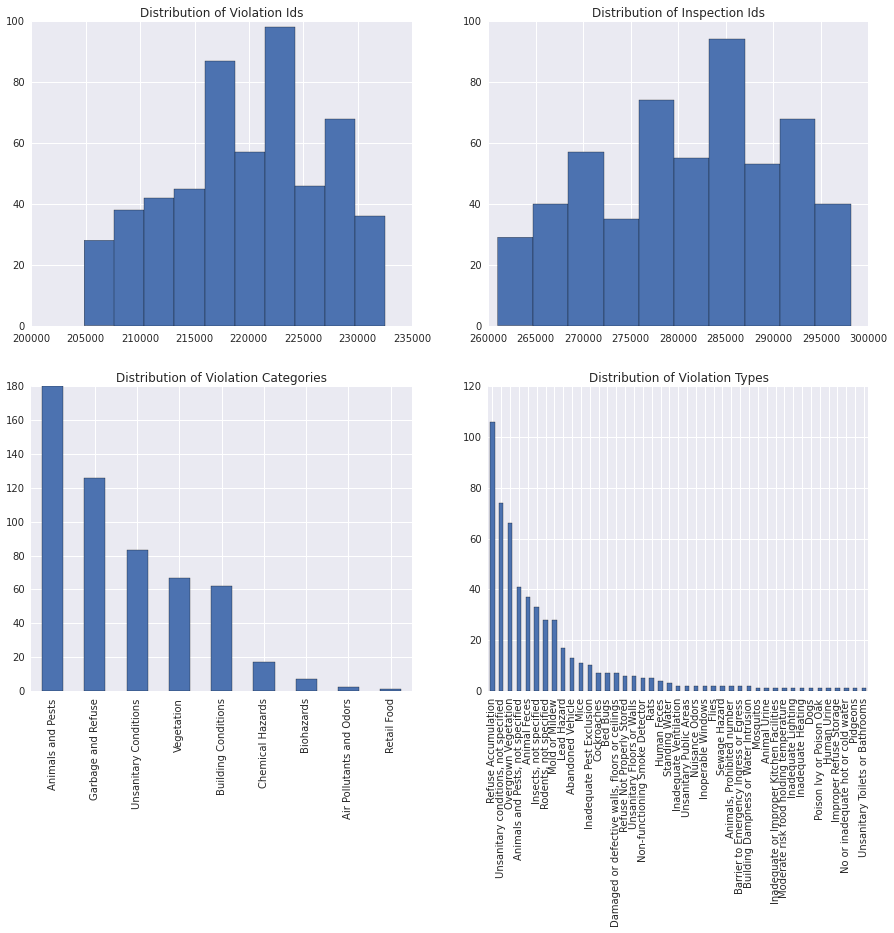

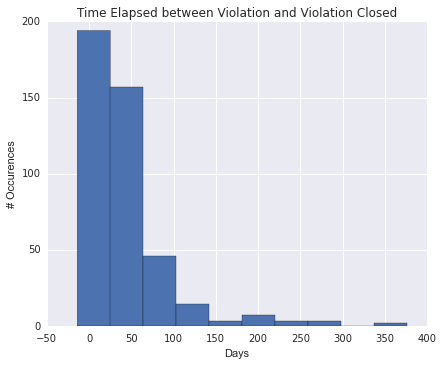

In [33]:
# exploratory analysis
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
df.violation_id.hist(ax=ax1)
ax1.set_title("Distribution of Violation Ids")
ax2 = fig.add_subplot(222)
df.inspection_id.hist(ax=ax2)
ax2.set_title("Distribution of Inspection Ids")
ax3 = fig.add_subplot(223)
df.violation_category.value_counts().plot(ax=ax3, kind='bar')
ax3.set_title("Distribution of Violation Categories")
ax4 = fig.add_subplot(224)
df.violation_type.value_counts().plot(ax=ax4, kind='bar')
ax4.set_title("Distribution of Violation Types")

fig2 = plt.figure(figsize=(15,12))
ax5 = fig2.add_subplot(221)
df.violation_duration_days.hist(ax=ax5)
ax5.set_xlabel("Days")
ax5.set_ylabel("# Occurences")
ax5.set_title("Time Elapsed between Violation and Violation Closed")


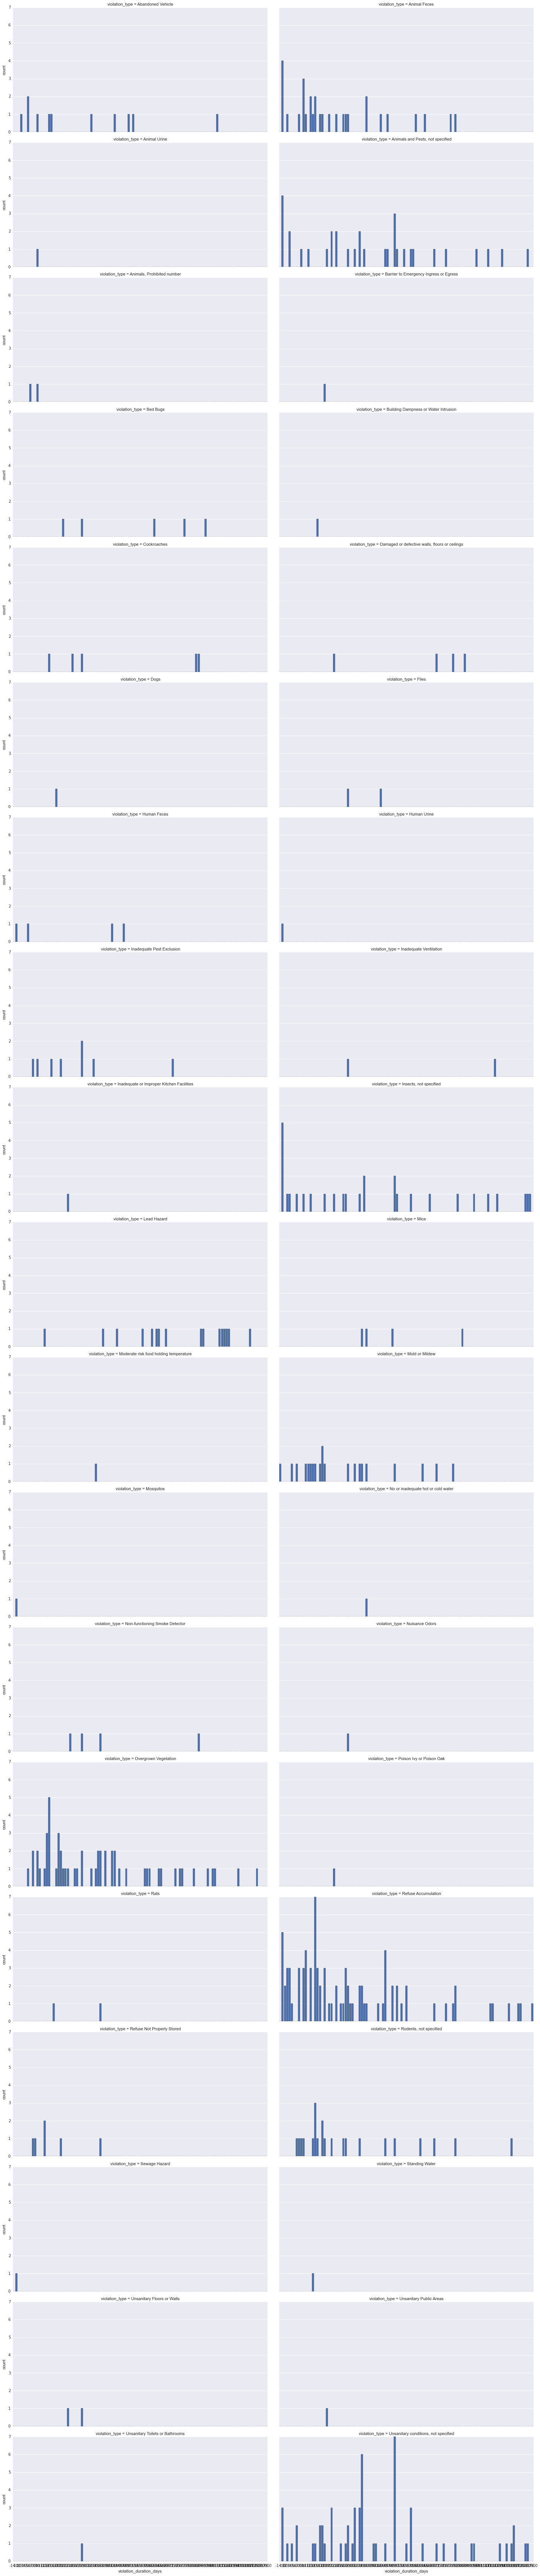

In [54]:
df_filter = df[df["violation_duration_days"].notnull()]
sns.factorplot(x="violation_duration_days", col="violation_type", data=df_filter, kind="bar", 
               col_wrap=2, size=5, aspect=2)

## Summary of Visualization Insights

* Most Frequent Violation Categories: "Animals and Pests", "Garbage and Refuse", "Unsanitary Conditions"
* Most Frequent Violation Types: "Refuse Accumulation", "Unsanitary Conditions", "Overgrown Vegitation"
* There is a very high positive correlation between violation_id and inspection_id, which could possible point to reasoning that some inspections are tied to violations.  More feature information about the type of inspection, and who is performing the inspection would be useful to understand what occurs at these particular violations regarding inspections.
* Additional features regarding the location information of violations would be helpful to understand why these categorical/type of violations are occuring more often for particular violation offenders.  As we can see there are some violation identifiers that are occuring much more than others, particular in the range ~221000-220400.
* We can see there is a large delta in the number of days from a violation to when it is closed for some violation ids.  This could  lead us to think that some violations take a while to be fixed.  As can be seen above, violation types, such as "unsanitary conditions" still exhibit occurences for large period, while "animal feces" can be more easily handled in terms of days before the violation is closed. 